In [1]:
#Importing the necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re 
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from collections import Counter
from tqdm import tqdm

import pickle

import os



In [2]:
from sklearn.metrics import confusion_matrix

### NAIVE BAYES MULTINOMIAL PROBLEM

### Step 1-Loading The Data

In [67]:
data=pd.read_csv('preprocessed_data.csv',nrows=50000)
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [68]:
data['project_is_approved'].value_counts()

1    41993
0     8007
Name: project_is_approved, dtype: int64

In [5]:
print("The shape of the donors choose dataframe is\n")
data.shape

The shape of the donors choose dataframe is



(50000, 9)

In [6]:
X=data.drop(['project_is_approved'],axis=1)
y=data['project_is_approved'].values
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [7]:
data.columns


Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

### Splitting the data into train and test

In [8]:
#STRATIFIED SAMPLING
#As we will be doing hyperparameter tuning using Gridsearch cv so no need to split in the cv set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,stratify=y)

print("The shapes of the trained datasets are\n")
print(X_train.shape)
print(y_train.shape)
print("The shape of the test datasets are\n")
print(X_test.shape)
print(y_test.shape)


The shapes of the trained datasets are

(33500, 8)
(33500,)
The shape of the test datasets are

(16500, 8)
(16500,)


### Making the features model ready that is encoding and numerical features

### Encoding Categorical Features

In [9]:
# Now we have to construct two sets one with bag of words approach and second with tfidf vectoriser approach

# Firstly for set 1 we will do the bag of words approach

# The first feature that we are converting into bow is essay

vect=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=50000)

vect.fit(X_train['essay'].values)

X_train_essay_bow=vect.transform(X_train['essay'].values)

X_test_essay_bow=vect.transform(X_test['essay'].values)

print("After vectorisations the shapes of respective datasets are \n")
print(X_train_essay_bow.shape)
print(" ")
print(X_test_essay_bow.shape)

After vectorisations the shapes of respective datasets are 

(33500, 50000)
 
(16500, 50000)


In [10]:
# The next feature that we consider for one hot encoding is the school state categorical feature
vec=CountVectorizer()
vec.fit(X_train['school_state'].values)
X_train_ohe=vec.transform(X_train['school_state'].values)
X_test_ohe=vec.transform(X_test['school_state'].values)
print("After vectorisations the shapes are\n")
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(vec.get_feature_names())


After vectorisations the shapes are

(33500, 51)
(16500, 51)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [11]:
# The next feature for one hot encoding is Teacher_prefix
vec=CountVectorizer()
vec.fit(X_train['teacher_prefix'].values)
X_train_teachpre_ohe=vec.transform(X_train['teacher_prefix'].values)
X_test_teachpre_ohe=vec.transform(X_test['teacher_prefix'].values)
print("After vectorization the shapes are\n")
print(X_train_teachpre_ohe.shape)
print(X_test_teachpre_ohe.shape)
print(vec.get_feature_names())

After vectorization the shapes are

(33500, 5)
(16500, 5)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [12]:
# Next feature is project_grade_category
vec=CountVectorizer()
vec.fit(X_train['project_grade_category'].values)
X_train_pgc_ohe=vec.transform(X_train['project_grade_category'].values)
X_test_pgc_ohe=vec.transform(X_test['project_grade_category'].values)
print("After vectorizations shapes are\n")
print(X_train_pgc_ohe.shape)
print(X_test_pgc_ohe.shape)
print(vec.get_feature_names())

After vectorizations shapes are

(33500, 4)
(16500, 4)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [13]:
# The next feature is is clean categories
vec=CountVectorizer()
vec.fit(X_train['clean_categories'].values)
X_train_cat_ohe=vec.transform(X_train['clean_categories'].values)
X_test_cat_ohe=vec.transform(X_test['clean_categories'].values)
print("Shapes after vectorisations are")
print(X_train_cat_ohe.shape)
print(X_test_cat_ohe.shape)
print(vec.get_feature_names())

Shapes after vectorisations are
(33500, 9)
(16500, 9)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [14]:
#Next feature is clean_subcategories
vec=CountVectorizer()
vec.fit(X_train['clean_subcategories'].values)
X_train_sub_ohe=vec.transform(X_train['clean_subcategories'].values)
X_test_sub_ohe=vec.transform(X_test['clean_subcategories'].values)
print("Shapes after Vectorizations\n")
print(X_train_sub_ohe.shape)
print(X_test_sub_ohe.shape)
print(vec.get_feature_names())


Shapes after Vectorizations

(33500, 30)
(16500, 30)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [15]:
#Encoding the price feature in the dataframe

from sklearn.preprocessing import Normalizer
normalizer=Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))
print("After Normalizations the shapes are\n")
print(X_train_price_norm.shape)
print(X_test_price_norm.shape)

After Normalizations the shapes are

(33500, 1)
(16500, 1)


In [16]:
# The numerical feature of teacher_number_of _previously_approved_projects
nor=Normalizer()
nor.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_pre_norm=nor.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_pre_norm=nor.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print("After normalizations the shapes are \n")
print(X_train_pre_norm.shape)
print(X_test_pre_norm.shape)


After normalizations the shapes are 

(33500, 1)
(16500, 1)


### Concatenating all the features 

In [17]:
from scipy.sparse import hstack
X_tr=hstack((X_train_essay_bow,X_train_ohe,X_train_pgc_ohe,X_train_teachpre_ohe,X_train_cat_ohe,X_train_sub_ohe,X_train_pre_norm,X_train_price_norm)).tocsr()
X_te=hstack((X_test_essay_bow,X_test_ohe,X_test_pgc_ohe,X_test_teachpre_ohe,X_test_cat_ohe,X_test_sub_ohe,X_test_pre_norm,X_test_price_norm)).tocsr()

print("The new data shapes after concatenation are\n")
print(X_tr.shape)
print(y_train.shape)
print(" ")
print(X_te.shape)
print(y_test.shape)

The new data shapes after concatenation are

(33500, 50101)
(33500,)
 
(16500, 50101)
(16500,)


In [18]:
type(X_tr)

scipy.sparse.csr.csr_matrix

### Hyper Parameter Tuning Using Gridsearch CV


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


In [20]:
mn=MultinomialNB(class_prior=[0.5,0.5])
parameters={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}


clf = GridSearchCV(mn, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)


results = pd.DataFrame.from_dict(clf.cv_results_)


results.head(10)



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.257594,0.253812,0.165813,0.201455,1e-05,{'alpha': 1e-05},0.657293,0.646890,0.642164,0.648782,0.006319,12,0.958839,0.959317,0.959076,0.959077,0.000195
1,0.072913,0.007378,0.020831,0.007365,0.0005,{'alpha': 0.0005},0.672501,0.664907,0.662534,0.666647,0.004251,9,0.952663,0.952537,0.953121,0.952773,0.000251
2,0.083805,0.007052,0.022626,0.006480,0.0001,{'alpha': 0.0001},0.665493,0.656718,0.653138,0.658450,0.005191,10,0.955617,0.955789,0.955967,0.955791,0.000143
3,0.087327,0.013015,0.028833,0.003395,0.005,{'alpha': 0.005},0.684253,0.676892,0.673676,0.678274,0.004427,7,0.946932,0.946161,0.947575,0.946889,0.000578
4,0.079721,0.004863,0.067949,0.058578,0.001,{'alpha': 0.001},0.676228,0.668885,0.665585,0.670233,0.004448,8,0.951160,0.950872,0.951674,0.951235,0.000332
5,0.088268,0.007187,0.028829,0.003425,0.05,{'alpha': 0.05},0.693116,0.686618,0.686510,0.688748,0.003089,4,0.938086,0.936387,0.938913,0.937795,0.001052
6,0.075542,0.003646,0.020833,0.007365,0.01,{'alpha': 0.01},0.687244,0.680275,0.678734,0.682085,0.003702,6,0.944698,0.943683,0.945402,0.944594,0.000706
7,0.085902,0.006378,0.031257,0.012764,0.1,{'alpha': 0.1},0.694733,0.688975,0.688651,0.690786,0.002794,3,0.934312,0.932243,0.935211,0.933922,0.001243
8,0.082010,0.003674,0.025895,0.003448,0.5,{'alpha': 0.5},0.695891,0.693322,0.691860,0.693691,0.001666,1,0.921083,0.917725,0.922241,0.920349,0.001915
9,0.080623,0.000473,0.049745,0.037138,1,{'alpha': 1},0.695059,0.693691,0.691435,0.693395,0.001494,2,0.911533,0.907338,0.913003,0.910625,0.002400


In [21]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [22]:
results.shape

(14, 17)

In [23]:
al=results['param_alpha']
print(al)

0      1e-05
1     0.0005
2     0.0001
3      0.005
4      0.001
5       0.05
6       0.01
7        0.1
8        0.5
9          1
10         5
11        10
12        50
13       100
Name: param_alpha, dtype: object


In [24]:
results.param_alpha=results.param_alpha.apply(lambda x: np.log(x))

In [25]:
results.param_alpha

0    -11.512925
1     -7.600902
2     -9.210340
3     -5.298317
4     -6.907755
5     -2.995732
6     -4.605170
7     -2.302585
8     -0.693147
9      0.000000
10     1.609438
11     2.302585
12     3.912023
13     4.605170
Name: param_alpha, dtype: float64

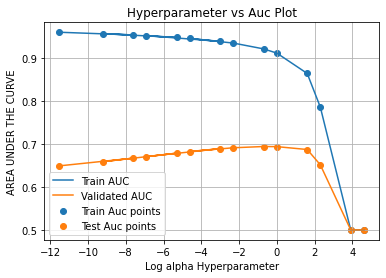

In [26]:
#Plotting the hyperparameter vs train auc and test auc plot

import math
train_auc=results['mean_train_score']
val_auc=results['mean_test_score']

al=results['param_alpha']

plt.plot(results['param_alpha'],train_auc,label='Train AUC')
plt.plot(results['param_alpha'],val_auc,label="Validated AUC")
plt.scatter(al,train_auc,label='Train Auc points')
plt.scatter(al,val_auc,label='Test Auc points')
plt.xlabel('Log alpha Hyperparameter')
plt.ylabel("AREA UNDER THE CURVE")
plt.title(label='Hyperparameter vs Auc Plot')
plt.grid()
plt.legend()
plt.show()

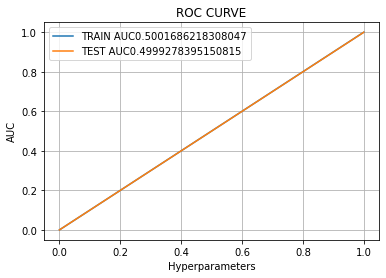

In [46]:
#From the above plot between train and cv and log of hyperparameter we can say that the best value of alpha is 50
# So we will now train our model on this value of alpha
mn=MultinomialNB(alpha=50)
mn.fit(X_tr,y_train)
y_train_pred=mn.predict(X_tr)
y_test_pred=mn.predict(X_te)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr,train_tpr,label="TRAIN AUC"+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="TEST AUC"+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.grid()
plt.title(label='ROC CURVE')
plt.xlabel("Hyperparameters")
plt.ylabel("AUC")
plt.show()

In [42]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)))
    print('\n')
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.00037277332976023254


THE CONFUSION MATRIX FOR TRAIN DATASET IS



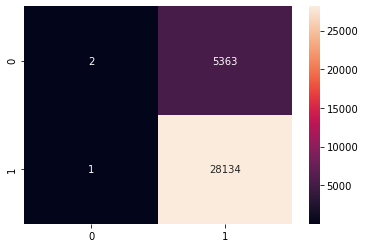

In [43]:
best_threshold=find_best_threshold(tr_thresholds,train_fpr,train_tpr)
cm_train=confusion_matrix(y_train,predict_with_best_t(y_train_pred,best_threshold))
print("THE CONFUSION MATRIX FOR TRAIN DATASET IS\n")
sns.heatmap(cm_train,annot=True,fmt='d')
plt.show()

THE CONFUSION MATRIX FOR TEST DATASET IS



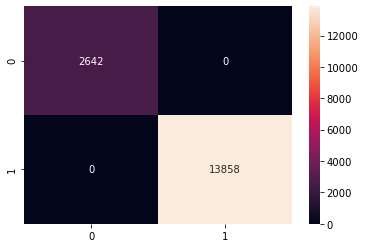

In [45]:

print("THE CONFUSION MATRIX FOR TEST DATASET IS\n")
cm_test=confusion_matrix(y_test,predict_with_best_t(y_test,best_threshold))
sns.heatmap(cm_test,annot=True,fmt='d')
plt.show()

### SET 2 using tfidf for essays

In [28]:
# Now we use tfidf for the next set
vec=TfidfVectorizer(min_df=10)
vec.fit(X_train['essay'].values)
X_train_essay_tfidf=vec.transform(X_train['essay'].values)
X_test_essay_tfidf=vec.transform(X_test['essay'].values)
print("After vectorisations with tf idf the shapes of the respective datatsets are\n")
print(X_train_essay_tfidf.shape)
print(" ")
print(X_test_essay_tfidf.shape)


After vectorisations with tf idf the shapes of the respective datatsets are

(33500, 10325)
 
(16500, 10325)


### Concatenating all the values for set 2

In [29]:
X_tr_=hstack((X_train_essay_tfidf,X_train_ohe,X_train_pgc_ohe,X_train_teachpre_ohe,X_train_cat_ohe,X_train_sub_ohe,X_train_pre_norm,X_train_price_norm)).tocsr()
X_te_=hstack((X_test_essay_tfidf,X_test_ohe,X_test_pgc_ohe,X_test_teachpre_ohe,X_test_cat_ohe,X_test_sub_ohe,X_test_pre_norm,X_test_price_norm)).tocsr()
print("The shapes of data after concatenation are\n")
print(X_tr_.shape)
print(" ")
print(y_train.shape)
print(" ")
print(X_te_.shape)
print(" ")
print(y_test.shape)

The shapes of data after concatenation are

(33500, 10426)
 
(33500,)
 
(16500, 10426)
 
(16500,)


### Performing the same Hyperparameter Tuning on the set 2

In [30]:
#We will use same Grid Search cv for hyperparameter tuning for this set

mb=MultinomialNB(class_prior=[0.5,0.5])

params={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf=GridSearchCV(mb,params,cv=3,scoring='roc_auc',return_train_score=True)

clf.fit(X_tr_,y_train)

res=pd.DataFrame.from_dict(clf.cv_results_)


In [31]:
res.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.043613,0.010251,0.016438,0.012512,1e-05,{'alpha': 1e-05},0.635773,0.632966,0.622656,0.630465,0.005639,9,0.867884,0.871913,0.876020,0.871939,0.003322
1,0.045642,0.002623,0.011992,0.000816,0.0005,{'alpha': 0.0005},0.648156,0.650418,0.641367,0.646647,0.003846,6,0.861426,0.865186,0.870202,0.865604,0.003595
2,0.042970,0.002161,0.012672,0.001690,0.0001,{'alpha': 0.0001},0.642524,0.642303,0.632368,0.639065,0.004737,7,0.865011,0.868910,0.873476,0.869132,0.003459
3,0.044310,0.004022,0.011987,0.000008,0.005,{'alpha': 0.005},0.656575,0.663512,0.657006,0.659031,0.003173,4,0.852109,0.855218,0.861164,0.856164,0.003757
4,0.047647,0.002858,0.013980,0.001423,0.001,{'alpha': 0.001},0.650801,0.654267,0.645788,0.650285,0.003480,5,0.859276,0.862922,0.868175,0.863457,0.003653
5,0.045641,0.002053,0.013330,0.000468,0.05,{'alpha': 0.05},0.659896,0.672036,0.671219,0.667717,0.005540,1,0.830550,0.831126,0.838523,0.833400,0.003630
6,0.044975,0.003264,0.012664,0.000463,0.01,{'alpha': 0.01},0.658689,0.667231,0.662002,0.662641,0.003516,3,0.847620,0.850326,0.856631,0.851526,0.003775
7,0.045981,0.002455,0.012986,0.001404,0.1,{'alpha': 0.1},0.656838,0.670185,0.671317,0.666114,0.006575,2,0.817086,0.815849,0.823786,0.818907,0.003487
8,0.047641,0.002054,0.018986,0.007251,0.5,{'alpha': 0.5},0.627188,0.638287,0.644205,0.636560,0.007054,8,0.748752,0.740902,0.747542,0.745732,0.003451
9,0.043651,0.000475,0.011654,0.000467,1,{'alpha': 1},0.602810,0.610873,0.618431,0.610705,0.006378,10,0.699726,0.690348,0.694258,0.694778,0.003846


In [32]:
res.param_alpha=res.param_alpha.apply(lambda x: np.log(x))

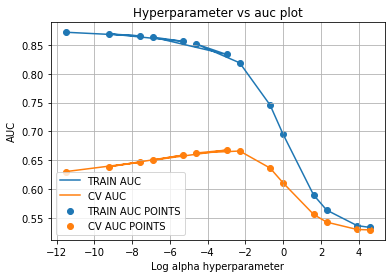

In [33]:
train_auc_=res['mean_train_score']
val_auc_=res['mean_test_score']
plt.plot(res['param_alpha'],train_auc_,label='TRAIN AUC')
plt.plot(res['param_alpha'],val_auc_,label='CV AUC')
plt.scatter(res['param_alpha'],train_auc_,label='TRAIN AUC POINTS')
plt.scatter(res['param_alpha'],val_auc_,label='CV AUC POINTS')
plt.grid()
plt.legend()
plt.title(label='Hyperparameter vs auc plot')
plt.xlabel('Log alpha hyperparameter')
plt.ylabel('AUC')
plt.show()

In [66]:
#From the above plot we can see that the best hyperparameter value for this plot is 100
mn=MultinomialNB(alpha=50,class_prior=[0.5,0.5])
mn.fit(X_tr_,y_train)
y_train_pre=mn.predict(X_tr_)
y_test_pre=mn.predict(X_te_)
tr_fpr,tr_tpr,tr_thresh=roc_curve(y_train,y_train_pre)
te_fpr,te_tpr,tr_thresh=roc_curve(y_test,y_test_pre)
plt.plot(tr_fpr,tr_tpr,label='TRAIN AUC'+str(auc(y_train,y_train_pre)))
plt.plot(te_fpr,te_tpr,label='TEST AUC'+str(auc(y_test,y_test_pre)))
plt.xlabel("Hyperparameter")
plt.ylabel('AUC')
plt.title(label='ROC CURVE')
plt.legend()
plt.grid()
plt.show()


ValueError: x is neither increasing nor decreasing : [1 1 1 ... 1 1 1].

In [65]:
from prettytable import PrettyTable

In [63]:
x=PrettyTable(['Vectorizer','Model','HyperParameter','Train AUC','Test AUC'])
x.add_row(['BOW','MultiNomialNB','50','0.500','0.499'])
x.add_row(['TFIDF','MultinomialNB','100','0.77','0.33'])
print(x)

+------------+---------------+----------------+-----------+----------+
| Vectorizer |     Model     | HyperParameter | Train AUC | Test AUC |
+------------+---------------+----------------+-----------+----------+
|    BOW     | MultiNomialNB |       50       |   0.500   |  0.499   |
|   TFIDF    | MultinomialNB |      100       |    0.77   |   0.33   |
+------------+---------------+----------------+-----------+----------+
